In [20]:
#include("../LiPoSID.jl")

using TSSOS

using LinearAlgebra

using DynamicPolynomials

using SymPy

using Plots

using Dates

using HDF5

using Optim

using Random

data_dir = "../DATA/"

γ_list = [ "0.079477",  "0.25133", "0.79477", "2.5133", "7.9477", "25.133",  "79.477", "251.33"]

γ_list_disp = [ "0.0795",  "0.2513", "0.7947", "2.5133", "7.9477", "25.133",  "79.477", "251.33"];

b⁰ = [0, 0, 1, 1]
b¹ = [0, 0, -1, 1]
bˣ = [1, 0, 0, 1]
bʸ = [1, 1, 0, 1]


function ⊗(A::AbstractMatrix, B::AbstractMatrix)
    return kron(A,B)
end

function LME_operator_symbolic(H, J)
    
    Id = I(2)   
    U = -im*(Id ⊗ H - transpose(H) ⊗ Id)
    D = sum( 2*transpose(j')⊗j-Id⊗(j'*j) - transpose(j)*transpose(j')⊗Id for j in J )/2 
    
    Lᴸᴹᴱ = U + D
    
    return Lᴸᴹᴱ
end

function SumCoeffs2(poly, s)
    p = SymPy.expand(poly)
    rest_poly = SymPy.subs(p, s => 0)
    degrees = range(1,convert(Int32,SymPy.degree(p, s)))
    
    obj = sum(p.coeff(s^i)^2 for i in degrees) #+ rest_poly^2  
    
    return obj
end 

function sympy_to_dynamicpoly(sympy_expr::Sym) #
    # Extract variables from the SymPy expression
    vars = free_symbols(sympy_expr)

    # Convert SymPy variables to string and then to Symbol
    var_symbols = [Symbol(string(v)) for v in vars]

    # Create DynamicPolynomials variables using @polyvar macro
    @eval begin
        @polyvar $(var_symbols...)
    end

    # Map SymPy variables to DynamicPolynomials variables
    var_map = Dict(vars[i] => eval(var_symbols[i]) for i in 1:length(vars))

    # Substitute using subs and convert to DynamicPolynomial
    dynamic_poly_expr = SymPy.subs(sympy_expr, var_map)
    dynamic_poly = eval(Meta.parse(string(dynamic_poly_expr)))
    return dynamic_poly
end


function TF_objective(Aˢʸᵐᵇ, Aˢⁱᵈ, b)

    @syms s

    Gˢʸᵐᵇ = inv(I(4)*s - Aˢʸᵐᵇ)*b

    Gˢⁱᵈ = inv(I(4)*s - Aˢⁱᵈ)*b

    #ΔG = SymPy.together.(Gˢʸᵐᵇ[1:3] - Gˢⁱᵈ[1:3])
    ΔG = SymPy.together.(Gˢʸᵐᵇ - Gˢⁱᵈ)

    polys = SymPy.numerator.(ΔG)

    obj = sum(SumCoeffs2.(polys.^2, s))

    #objective = sympy_to_dynamicpoly(obj)

    return obj

end

function read_Ac(models_file_name, γ)
    h5open(models_file_name, "r") do file
        Ac = read(file["gamma_"*string(γ)]["Ac"])
        return Ac
    end
end

function dmd_Ac(γ)

    data_dir = "../DATA/"
    
    ρᵉ, tᵉ = LiPoSID.get_rho_series(data_dir*"State_B1_2CUT_data.h5", γ)
    ρᵍ, tᵍ = LiPoSID.get_rho_series(data_dir*"State_B2_2CUT_data.h5", γ)
    ρˣ, tˣ = LiPoSID.get_rho_series(data_dir*"State_B3_2CUT_data.h5", γ)
    ρʸ, tʸ = LiPoSID.get_rho_series(data_dir*"State_B4_2CUT_data.h5", γ)

    Δt = tᵉ[2]-tᵉ[1]

    lᵉ = length(ρᵉ); lᵍ = length(ρᵍ); lˣ = length(ρˣ); lʸ = length(ρʸ)
    lᵐᵃˣ = min(lᵉ, lᵍ,  lˣ, lʸ)  #choose time limit by shortest series

    Aᴰᴹᴰ⁻ˢᴮ = LiPoSID.direct_DMD_01XY_b4_A([ρᵉ[1:lᵐᵃˣ], ρᵍ[1:lᵐᵃˣ], ρˣ[1:lᵐᵃˣ], ρʸ[1:lᵐᵃˣ]])
    Acᴰᴹᴰ⁻ˢᴮ = log(Aᴰᴹᴰ⁻ˢᴮ)/Δt

    return Acᴰᴹᴰ⁻ˢᴮ

end

function sb_TF_objective(γ, Acˢʸᵐᵇ)
    models_file_name="../MODELS/DMD_b4_LTI_trn4_2023-Nov-29_at_17-38.h5"
    Acᴰᴹᴰ = read_Ac(models_file_name, γ)
    obj =  TF_objective(Acˢʸᵐᵇ, Acᴰᴹᴰ, bˣ) + TF_objective(Acˢʸᵐᵇ, Acᴰᴹᴰ, bʸ) + TF_objective(Acˢʸᵐᵇ, Acᴰᴹᴰ, b¹) + TF_objective(Acˢʸᵐᵇ, Acᴰᴹᴰ, b⁰)
    objective = sympy_to_dynamicpoly(obj)
    return objective
end

#Functions for plotting heatmaps

function plot_TF_objective(γ, Aᴸᴹᴱ)

    objective = sb_TF_objective(γ, Aᴸᴹᴱ)

    function f(γ_val, ω_val)
        return objective(variables(objective)[1] => γ_val, variables(objective)[2] => ω_val)
    end
    
    function f(γ_val)
        return objective(variables(objective)[1] => γ_val)
    end

    γᶠ = parse(Float64, γ)

    w = range(-30, 30, length=1000)
    g = range(-30*γᶠ, 30*γᶠ, length=1000)
    #g = range(-10, 10, length=500)
    z = @. f(g', w)

    heatmap(g, w, log.(z))
    contour!(g, w, log.(z))
    title!("γ = "*string(γ))

end


function plot_TF_objective(γ, Aᴸᴹᴱ, γ_lim)

    objective = sb_TF_objective(γ, Aᴸᴹᴱ)

    function f(γ_val, ω_val)
        return objective(variables(objective)[1] => γ_val, variables(objective)[2] => ω_val)
    end
    
    function f(γ_val)
        return objective(variables(objective)[1] => γ_val)
    end

    γᶠ = parse(Float64, γ)

    w = range(-30, 10, length=1000)
    g = range(-γ_lim, γ_lim, length=1000)
    #g = range(-10, 10, length=500)
    z = @. f(g', w)

    #heatmap(g, w, log.(z))
    contour(g, w, log.(z))
    #title!("γ = "*string(γ))
    xlabel!("γ")
    ylabel!("ω")

end

function local_rand_min(p)

    pd = p / maximum(abs.(coefficients(p)))

    # find variable scaling
    scale = scaling_poly(pd)

    # scale the polynomial
    p_scaled = DynamicPolynomials.subs(pd, variables(pd) => scale .* variables(pd))

    num_iterations = 1000

    # Initialize the best minimizer and the minimum value
    best_minimizer = nothing
    best_min_value = Inf

    num_of_variables = length(variables(pd))

    for _ in 1:num_iterations
        # Generate a random initial condition
        initial_point = rand(num_of_variables).*250

        # Run local optimization
        result = Optim.optimize(p_scaled, initial_point, BFGS())
        #println(Optim.minimum(result))

        # Update the best minimizer if a better one is found
        if Optim.minimum(result) < best_min_value
            
            best_minimizer = Optim.minimizer(result)
            best_min_value = Optim.minimum(result)
            
        end

    end

    minimizer_scaled = scale .* best_minimizer

    solution = variables(p_scaled) => minimizer_scaled

end

function scaling_poly(p::Polynomial)

    X = transpose(hcat([exponents(t) for t in terms(p)]...))

    # Get the scaling via linear regression
    scaling = X \ log.(abs.(coefficients(p)))

    exp.(abs.(scaling)) # 
end

function tssos_min(p)
    
    ################################################################################################
    #
    #   Try TSSOS on polynomial with scaled variables
    #
    ################################################################################################

    pd = p #/ maximum(abs.(coefficients(p)))

    # minimize
    # minimizer_scaled_tssos = nothing

    try
        opt,sol,data = tssos_first(pd, variables(pd), QUIET=true, solution=true, newton=true);
        previous_sol = sol

        while ~isnothing(sol)
            previous_sol = sol
            opt,sol,data = tssos_higher!(data; QUIET=true, solution=true);
        end

        global minimizer_tssos = previous_sol
    
    catch
        println("TSSOS failed")
        global minimizer_scaled_tssos = nothing

    end

    best_solution = variables(p) => minimizer_tssos

end                    

tssos_min (generic function with 1 method)

In [21]:
using SymPy


ω = SymPy.symbols("ω", real=true)
γ = SymPy.symbols("γ", real=true)

Hᴸᴹᴱ = [ ω        0
         0        0   ]


Jᴸᴹᴱ = [ 0     γ
         0     0. + 0im  ]

Lᴸᴹᴱ = LME_operator_symbolic(Hᴸᴹᴱ, [Jᴸᴹᴱ])

M =   [ 0  0    1  1
        1  -im  0  0 
        1  im   0  0
        0  0   -1  1 ]/2



Aᴸᴹᴱ = real.(inv(M) * Lᴸᴹᴱ * M)

4×4 Matrix{Sym{PyCall.PyObject}}:
 -0.5*γ^2     1.0⋅ω         0        0
   -1.0⋅ω  -0.5*γ^2         0        0
        0         0  -1.0*γ^2  1.0*γ^2
        0         0         0        0

In [3]:
Aˢ = [ -γ/2  ω      0      0  
       -ω   -γ/2    0      0
        0    0     -γ      γ
        0    0      0      0    ] #==#

4×4 Matrix{Sym{PyCall.PyObject}}:
 -γ/2     ω   0  0
   -ω  -γ/2   0  0
    0     0  -γ  γ
    0     0   0  0

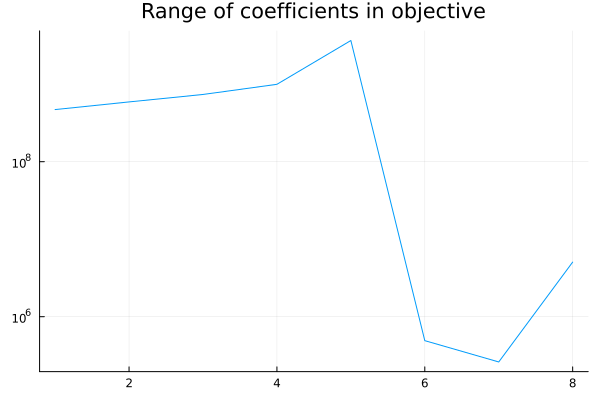

In [22]:
function coef_range(obj)
    maximum(abs.(coefficients(obj)))/minimum(abs.(coefficients(obj)))
end

coef_ranges = []

for γᵢ in  γ_list
    objective = sb_TF_objective(γᵢ, Aˢ) #Aᴸᴹᴱ)
    push!(coef_ranges, coef_range(objective))
end
#pyplot()
plot(coef_ranges, yscale=:log10, legend=false)
title!("Range of coefficients in objective")

In [23]:
date_and_time_string =  string(Dates.format(now(), "yyyy-u-dd_at_HH-MM"))
models_file = "DMD_TS_POP_w&g2_pd_bx_"*date_and_time_string * ".h5"

models_dir = "../MODELS/"

for γᵢ in  γ_list

    print(γᵢ, "-")
    
    objective = sb_TF_objective(γᵢ, Aᴸᴹᴱ)
    
    solution = local_rand_min(objective)

    rnd_w = DynamicPolynomials.subs(ω, solution)
    rnd_g = DynamicPolynomials.subs(γ, solution)

    println(rnd_g)


    h5open(models_dir*models_file,"cw") do fid  # read-write, create file if not existing, preserve existing contents

        γ_group = create_group(fid, "gamma_"*γᵢ)
            
        #γ_group["tssos_w"] = convert(Float64, tssos_w )
        #γ_group["tssos_g"] = sqrt(abs(convert(Float64,tssos_g2)))
        γ_group["w"] = convert(Float64, rnd_w )
        γ_group["g"] = convert(Float64,rnd_g)

        γ_group["coef_range"] = coef_range(objective)
                        
    end
   

end

println(date_and_time_string)

0.079477-

0.39487609364171083
0.25133-

-0.7054675010023688
0.79477-

1.258743528218355
2.5133-

-2.263765580031467
7.9477-

4.1382386885358216
25.133-

4.171727476496043e-12
79.477-

-1.1228294478076535
251.33-

-1.238298429611606e-11
2024-Jan-10_at_13-20
